In [65]:
##############
#K. David Roell CFPB 7/12/16
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############
from collections import OrderedDict
import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import sqrt
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')
#from macro_sql import Q076 
with open('quality_sql.json') as f: #FIXME change to quality_sql.json and refactor the rest of code
    edit_sql = json.load(f)
    
#parameter format for local use #consider changing hmdamaster to roellk if db changes cause a fail
params = {
'dbname':'hmdamaster',
'user':'roellk',
'password':'',
'host':'localhost',
}

try:
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    print("i'm connected")

except psycopg2.Error as e: #if database connection results in an error print the following
    print("I am unable to connect to the database: ", e)

i'm connected


In [66]:
#load single bank data as dataframe
loanType = 'all'
#bank_df = pd.read_csv('data/income_to_amount_dist_conv.csv') #conventional loans
bank_df = pd.read_csv('data/income_to_amount_dist_{loanType}.csv'.format(loanType=loanType)) # VA loans
#FHA loans
#RHS loans
#all loans

inc_df = bank_df.copy() # split income df out to sort values by income for graphing cumulative income percent
#these data are for single family, conventional, owner occupied, first lien, home purchase loans at the national level
#other analysis will be used for each loan product, lien status, geography, and other variables as appropriate

In [67]:
#sort data frame by amount field, this is useful because multiple years are present
bank_df.sort_values(by='amount', inplace=True)
inc_df.sort_values(by='income', inplace=True)
inc_df.head()

,year,income,amount
0,2014,1,1
803511,2010,1,46
803512,2010,1,47
803513,2010,1,48
803514,2010,1,49


In [68]:
#bank_df = bank_df[bank_df.year == 2014].copy() #select single year
bank_df.income = bank_df.income.map(int) #convert data to numeric
bank_df.amount = bank_df.amount.map(int) #convert data to numeric
bank_df['mult'] = bank_df.amount/bank_df.income #create amount to income multiple

#create percent and cumulative percents by value
bank_df['pct_amt'] = bank_df['amount']/bank_df['amount'].sum() #calculate percent of total amount for each row
bank_df['cumul_amt_pct'] = bank_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
bank_df['pct_inc'] = bank_df['income']/bank_df['income'].sum()
bank_df['cumul_inc_pct'] = bank_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
cnt_amt_df = pd.DataFrame(bank_df.groupby(['amount']).pct_amt.count())
cnt_amt_df.rename(columns={'pct_amt':'count_amt'}, inplace=True)
cnt_amt_df['amount'] = cnt_amt_df.index
cnt_amt_df['pct_of_cnt'] = cnt_amt_df.count_amt.divide(other=cnt_amt_df.count_amt.sum())
cnt_amt_df['cumul_pct_cnt'] = cnt_amt_df.pct_of_cnt.cumsum()

#create percent and cumulative percents by value
inc_df['pct_amt'] = inc_df['amount']/inc_df['amount'].sum() #calculate percent of total amount for each row
inc_df['cumul_amt_pct'] = inc_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
inc_df['pct_inc'] = inc_df['income']/inc_df['income'].sum()
inc_df['cumul_inc_pct'] = inc_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
total = inc_df.groupby(['income']).pct_inc.count().sum()

#create percent and cumulative percents by count and count times amount
cnt_inc_df = pd.DataFrame(inc_df.groupby(['income']).pct_inc.count())
cnt_inc_df.rename(columns={'pct_inc':'count_inc'}, inplace=True)
cnt_inc_df['income'] = cnt_inc_df.index
cnt_inc_df['pct_of_cnt'] = cnt_inc_df.count_inc.divide(other=cnt_inc_df.count_inc.sum())
cnt_inc_df['cumul_pct_cnt'] = cnt_inc_df.pct_of_cnt.cumsum()


In [69]:
print(bank_df.head()) #check dataframe for columns
print(inc_df.head())

         year  income  amount      mult       pct_amt  cumul_amt_pct  \
0        2014       1       1  1.000000  8.055384e-10   8.055384e-10   
661397   2011      96       1  0.010417  8.055384e-10   1.611077e-09   
660855   2011      95       1  0.010526  8.055384e-10   2.416615e-09   
1861832  2005      36       1  0.027778  8.055384e-10   3.222154e-09   
660320   2011      94       1  0.010638  8.055384e-10   4.027692e-09   

              pct_inc  cumul_inc_pct  
0        1.435143e-09   1.435143e-09  
661397   1.377737e-07   1.392088e-07  
660855   1.363386e-07   2.755474e-07  
1861832  5.166514e-08   3.272125e-07  
660320   1.349034e-07   4.621159e-07  
        year  income  amount       pct_amt  cumul_amt_pct       pct_inc  \
0       2014       1       1  8.055384e-10   8.055384e-10  1.435143e-09   
803511  2010       1      46  3.705477e-08   3.786030e-08  1.435143e-09   
803512  2010       1      47  3.786030e-08   7.572061e-08  1.435143e-09   
803513  2010       1      48  3.8

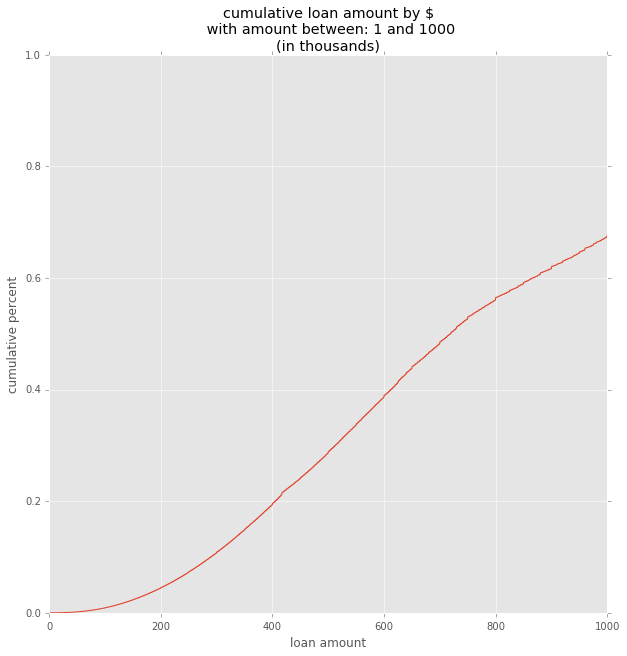

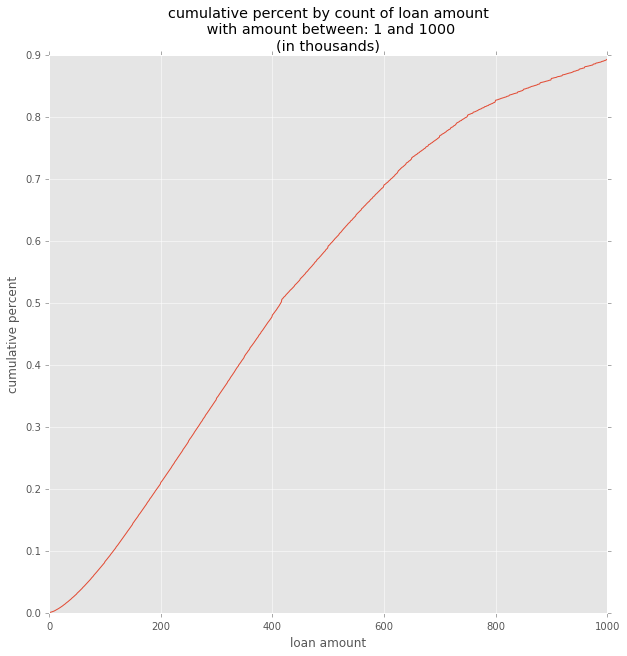

In [70]:
#FIXME add cutoff field name and cutoff value to title
#graph cumulative sum of % of income and % of loan amount 
amt_min = bank_df.amount.min()
amt_max = 1000#bank_df.amount.max()

y = bank_df.cumul_amt_pct[(bank_df.amount < amt_max) & (bank_df.amount > amt_min)]
x = bank_df.amount[(bank_df.amount < amt_max) & (bank_df.amount > amt_min)]
cumul_pct = plt.figure(figsize=(10,10))
plt.plot(x,y)
ax = plt.subplot()
ax.set_ylim([0,1])
plt.title('cumulative loan amount by $\n with amount between: {amt_min} and {amt_max}\n(in thousands)'.format(amt_min=amt_min, amt_max=amt_max))
plt.ylabel('cumulative percent')
plt.xlabel('loan amount')
plt.show(cumul_pct)

#y1 = bank_df.cumul_cnt_pct_amt[bank_df[cut_field] < amt_cutoff]
x1 = cnt_amt_df.amount[(cnt_amt_df.amount < amt_max) & (cnt_amt_df.amount > amt_min)]
y1 = cnt_amt_df.cumul_pct_cnt[(cnt_amt_df.amount < amt_max) & ( cnt_amt_df.amount > amt_min)]
cumul_cnt = plt.figure(figsize=(10,10))
plt.plot(x1,y1)
plt.xlabel('loan amount')
plt.ylabel('cumulative percent')
plt.title('cumulative percent by count of loan amount\n with amount between: {amt_min} and {amt_max}\n(in thousands)'.format(amt_min=amt_min, amt_max=amt_max))
plt.show(cumul_cnt)


#FIXME modify these graphs by reducing the range of the x axis to see the cumulative curve better
#measureing the $ value of loans shows a high degree of skew due to very large loan amounts
#cutting the tail off the data may be more informative
#the majority of loans by count are under 450-500k, but the raw $ value majority is closer to 2million

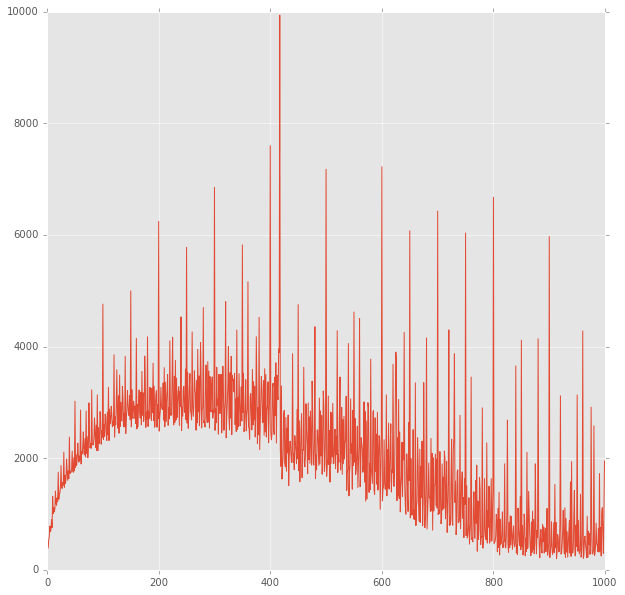

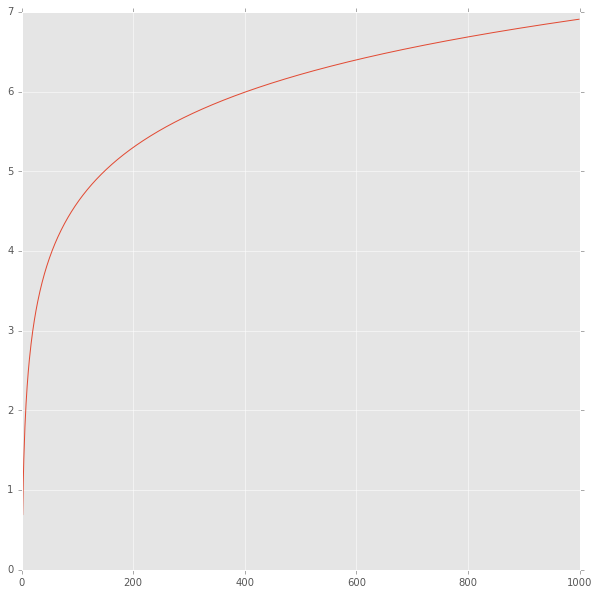

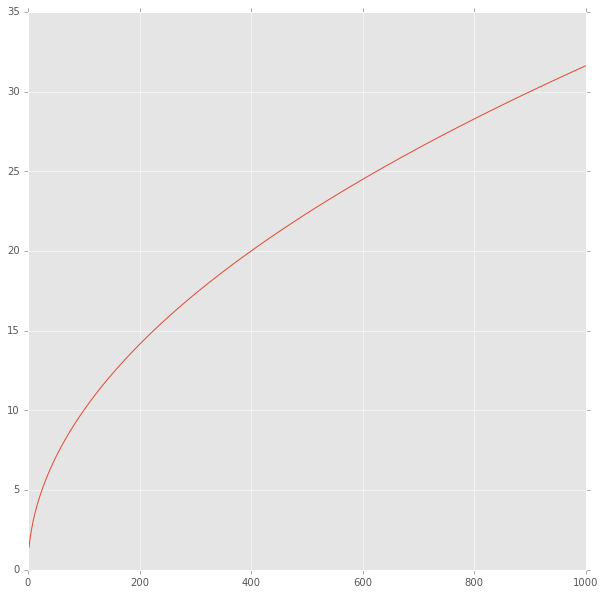

In [71]:
from math import log, sqrt
amt_dist = pd.DataFrame(bank_df.groupby('amount').mult.count())
amt_dist.rename(columns={'mult':'count_amt'},inplace=True)
amt_dist['amount'] = amt_dist.index
amt_dist['amt_log'] = amt_dist.amount.apply(log)
amt_dist['amt_sqrt'] = amt_dist.amount.apply(sqrt)
amt_dist.head()
amt_fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
amt_y1 = amt_dist.count_amt[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]
amt_x1 = amt_dist.amount[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]


plt.plot(amt_x1,amt_y1)
plt.show(amt_fig)

#plot logs of amount
log_fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
amt_y2 = amt_dist.amt_log[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]
plt.plot(amt_x1,amt_y2)
plt.show(log_fig)

#plot sqrt of amount
sqrt_fig = plt.figure(figsize=(10,10))
amt_y3 = amt_dist.amt_sqrt[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]
plt.plot(amt_x1,amt_y3)
plt.show(sqrt_fig)



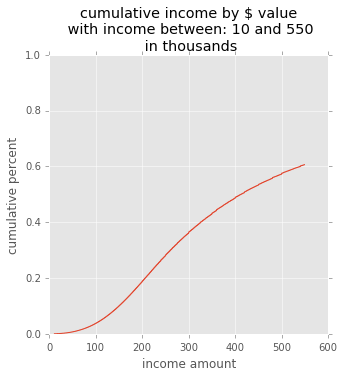

In [72]:
#showing cumulative percent of count of loans by income
#inc_cutoff allows trims max end of distribution
inc_min = 10
inc_max = 550
y = inc_df.cumul_inc_pct[(inc_df.income < inc_max) & (inc_df.income > inc_min)]
x = inc_df.income[(inc_df.income < inc_max) &(inc_df.income > inc_min)]

cumul_inc = plt.figure(figsize=(5,5))
plt.plot(x,y)
ax = plt.subplot()
ax.set_ylim([0,1])
plt.title('cumulative income by $ value\n with income between: {inc_min} and {inc_max}\n in thousands'.format(inc_min=inc_min, inc_max=inc_max))
plt.ylabel('cumulative percent')
plt.xlabel('income amount')
plt.show(cumul_inc)


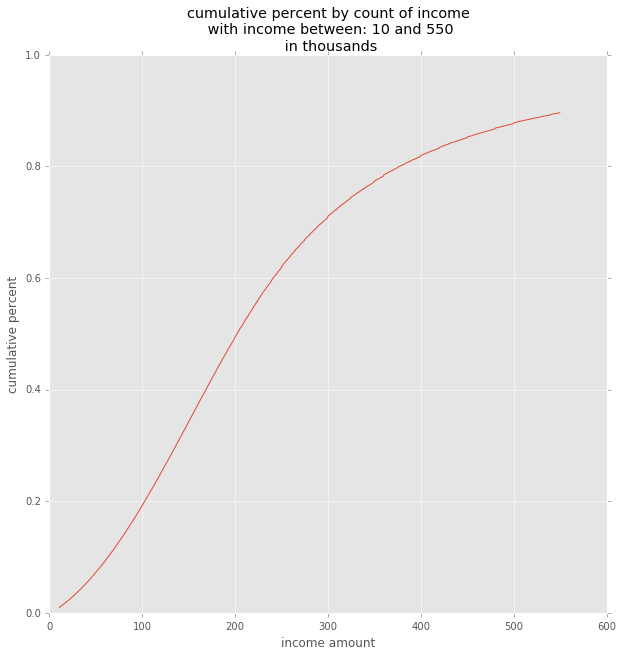

In [73]:
x1 = cnt_inc_df.income[(cnt_inc_df.income < inc_max) & (cnt_inc_df.income > inc_min)]
y1 = cnt_inc_df.cumul_pct_cnt[(cnt_inc_df.income < inc_max) & (cnt_inc_df.income > inc_min)]
cumul_cnt = plt.figure(figsize=(10,10))
plt.plot(x1,y1)
ax = plt.subplot()
ax.set_ylim([0,1])
plt.xlabel('income amount')
plt.ylabel('cumulative percent')
plt.title('cumulative percent by count of income\n with income between: {inc_min} and {inc_max}\n in thousands'.format(inc_min=inc_min, inc_max=inc_max))
plt.show(cumul_cnt)

582.78309323 std
538.235988543 mean
416.0 median
6000.0 max mult
0.000357142857143 min mult
1995.0 q98
675.0 q75
231.0 q25
37.0 q02
444.0 iqr
-435.0 min_q 1341.0 max_q


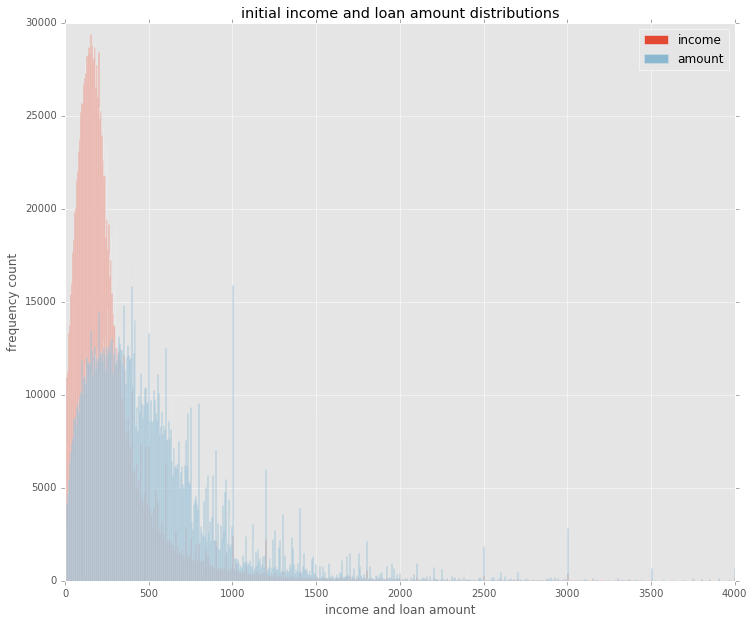

In [74]:
#calculate descriptive stats
print(bank_df.amount.std(), 'std') 
print(bank_df.amount.mean(), 'mean') 
print(bank_df.amount.median(), 'median')
print(bank_df.mult.max(), 'max mult')
print(bank_df.mult.min(), 'min mult')
print(bank_df.amount.quantile(q=.98), 'q98')
print(bank_df.amount.quantile(q=.75), 'q75')
print(bank_df.amount.quantile(q=.25), 'q25')
print(bank_df.amount.quantile(q=.02), 'q02')
q1 = bank_df.amount.quantile(q=.25)
q3 = bank_df.amount.quantile(q=.75)
q98 = bank_df.amount.quantile(q=.98) #potential upper bound for quality
q2 = bank_df.amount.quantile(q=.02) #potential lower bound for quality
iqr =(q3 - q1)
print(iqr, 'iqr')
min_q = q1 - 1.5*iqr #potential lower bound for quality
max_q = q3 + 1.5*iqr #potential upper bound for quality
print(min_q, 'min_q', max_q, 'max_q')


amt = bank_df.amount #get data as series for graphing
inc = bank_df.income #get data as series for graphing
bins = np.linspace(0,4000, 1000) #set ranges and number of bins
bank_viz = plt.figure(figsize=(12,10)) #set plot size
plt.hist(inc, bins, label='income', alpha=1) #plot histogram of income
plt.hist(amt, bins, label='amount', alpha=.5) #plot histogram of loan amount
plt.legend(loc='upper right') #turn on legend and set location
plt.title('initial income and loan amount distributions')
plt.xlabel('income and loan amount')
plt.ylabel('frequency count')
plt.show()
#FIXME add 2 box plot viz

name 0 to 20
std 192.732892579
mean 167.342617297
median 127.0
max_mult 6000.0
med_mult 12.090909090909092
min_mult 0.0526315789474
q98 620.0
q02 8.0
q75 212.0
q25 65.0
iqr 147.0
min_q -155.5
max_q 432.5
count of loans 46101
pct of total loans 1.99879987895


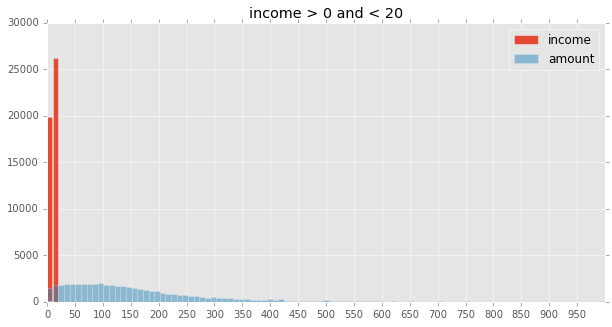

name 20 to 50
std 564.708254155
mean 205.61611202
median 177.0
max_mult 2375.0
med_mult 5.121951219512195
min_mult 0.0204081632653
q98 600.0
q02 9.0
q75 273.0
q25 89.0
iqr 184.0
min_q -187.0
max_q 549.0
count of loans 115479
pct of total loans 5.00682005208


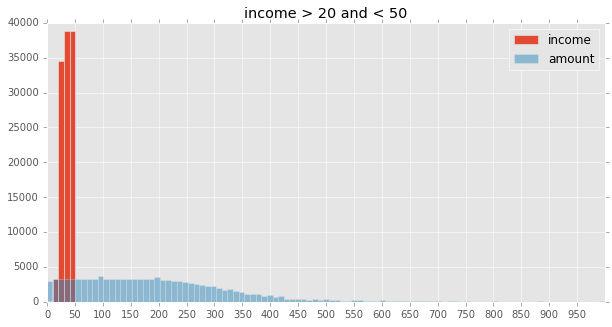

name 50 to 80
std 462.066156943
mean 256.300640863
median 238.0
max_mult 1718.51851852
med_mult 3.6973684210526314
min_mult 0.0126582278481
q98 635.0
q02 14.0
q75 356.0
q25 122.0
iqr 234.0
min_q -229.0
max_q 707.0
count of loans 154011
pct of total loans 6.67745099144


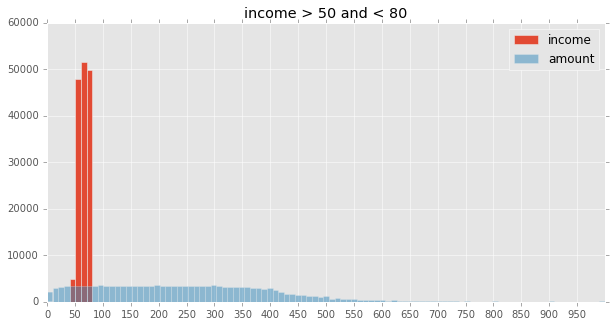

name 80 to 110
std 412.562600252
mean 311.162530466
median 297.0
max_mult 1060.0
med_mult 3.141304347826087
min_mult 0.00917431192661
q98 700.0
q02 24.0
q75 440.0
q25 155.0
iqr 285.0
min_q -272.5
max_q 867.5
count of loans 186685
pct of total loans 8.0940967745


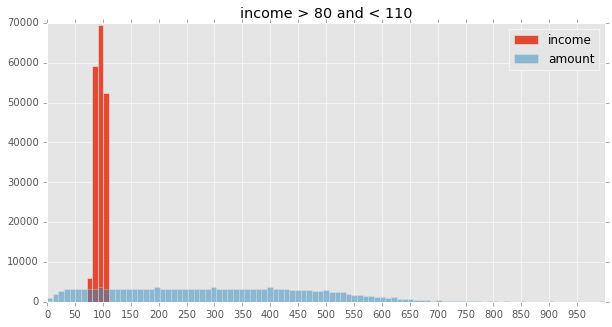

name 110 to 140
std 292.424861324
mean 359.119923773
median 345.0
max_mult 646.363636364
med_mult 2.7709923664122136
min_mult 0.00719424460432
q98 785.0
q02 35.0
q75 507.0
q25 187.0
iqr 320.0
min_q -293.0
max_q 987.0
count of loans 208324
pct of total loans 9.03229834454


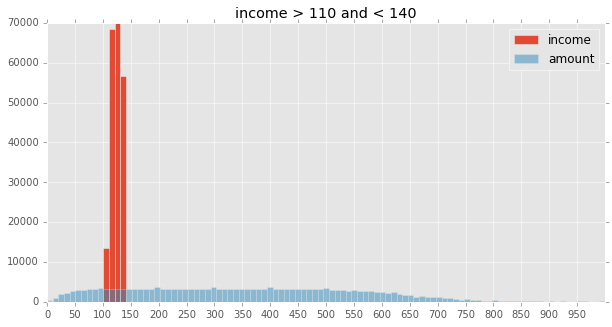

name 140 to 170
std 234.144989048
mean 400.688437119
median 381.0
max_mult 59.6026490066
med_mult 2.4689655172413794
min_mult 0.00591715976331
q98 900.0
q02 50.0
q75 557.0
q25 217.0
iqr 340.0
min_q -293.0
max_q 1067.0
count of loans 215154
pct of total loans 9.32842648001


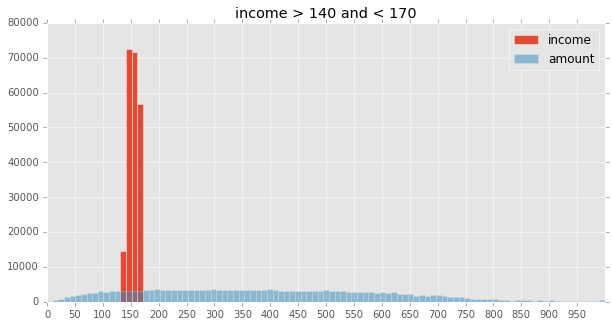

name 170 to 200
std 253.309896901
mean 440.316249619
median 412.0
max_mult 65.9340659341
med_mult 2.2429378531073447
min_mult 0.00502512562814
q98 987.0
q02 63.0
q75 601.0
q25 247.0
iqr 354.0
min_q -284.0
max_q 1132.0
count of loans 206571
pct of total loans 8.95629356834


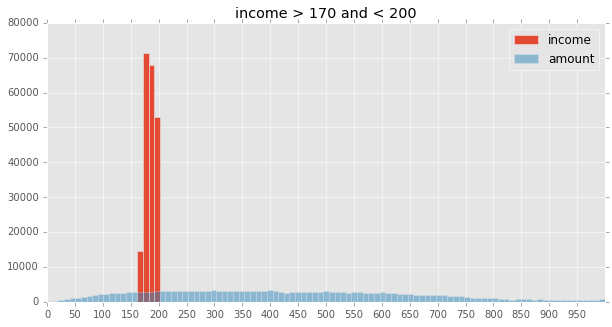

name 200 to 230
std 315.770975814
mean 482.859347267
median 451.0
max_mult 315.492957746
med_mult 2.10762331838565
min_mult 0.00442477876106
q98 1105.0
q02 76.0
q75 648.0
q25 276.0
iqr 372.0
min_q -282.0
max_q 1206.0
count of loans 185926
pct of total loans 8.0611888309


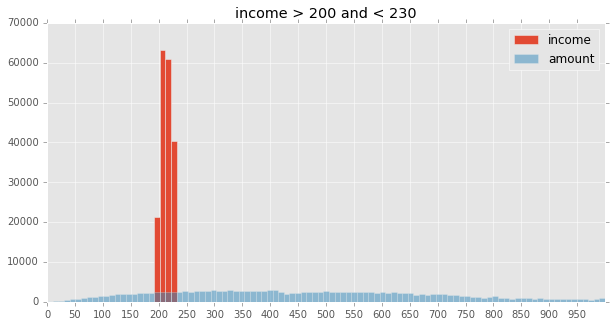

name 230 to 260
std 311.684551981
mean 526.00434639
median 492.0
max_mult 84.0336134454
med_mult 2.0166666666666666
min_mult 0.00395256916996
q98 1250.0
q02 85.0
q75 700.0
q25 301.0
iqr 399.0
min_q -297.5
max_q 1298.5
count of loans 154381
pct of total loans 6.69349307199


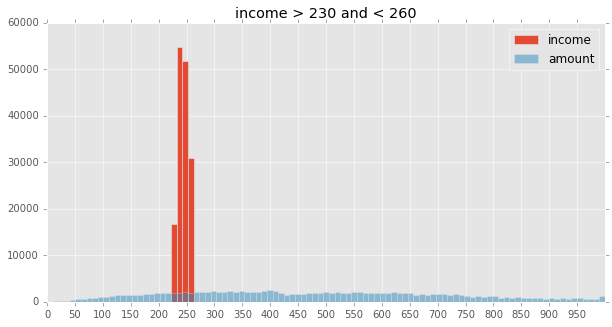

name 260 to 290
std 451.965428306
mean 566.985718865
median 527.0
max_mult 293.165467626
med_mult 1.9263157894736842
min_mult 0.00353356890459
q98 1357.0
q02 95.0
q75 744.0
q25 323.0
iqr 421.0
min_q -308.5
max_q 1375.5
count of loans 124780
pct of total loans 5.41008327141


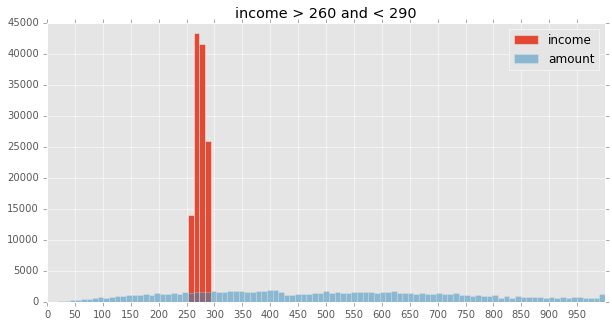

name 290 to 320
std 359.483520279
mean 611.29774042
median 566.0
max_mult 43.3333333333
med_mult 1.8639240506329113
min_mult 0.00324675324675
q98 1474.52
q02 98.0
q75 808.0
q25 342.0
iqr 466.0
min_q -357.0
max_q 1507.0
count of loans 101125
pct of total loans 4.38447404088


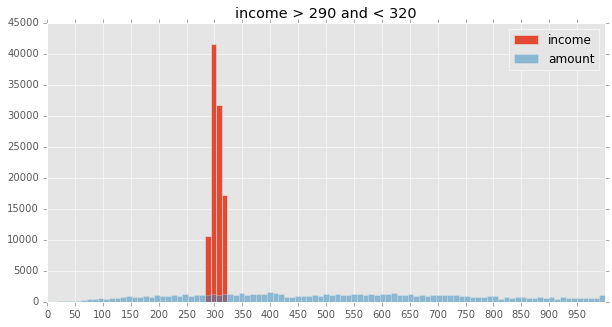

name 320 to 350
std 382.09319948
mean 651.033848209
median 600.0
max_mult 18.0303030303
med_mult 1.7988165680473374
min_mult 0.00290697674419
q98 1575.0
q02 102.0
q75 868.0
q25 360.0
iqr 508.0
min_q -402.0
max_q 1630.0
count of loans 80861
pct of total loans 3.5058883107


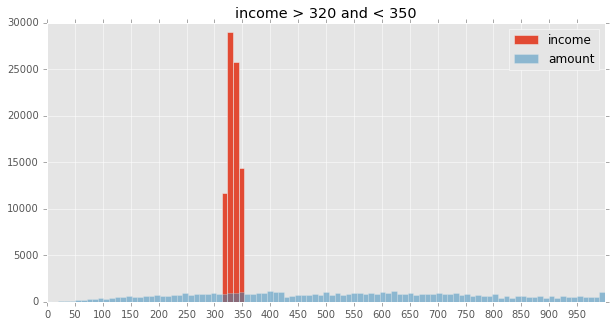

name 350 to 380
std 414.20031228
mean 684.664609378
median 624.0
max_mult 24.7282608696
med_mult 1.713091922005571
min_mult 0.00268817204301
q98 1724.0
q02 100.0
q75 919.0
q25 368.0
iqr 551.0
min_q -458.5
max_q 1745.5
count of loans 69671
pct of total loans 3.02072376665


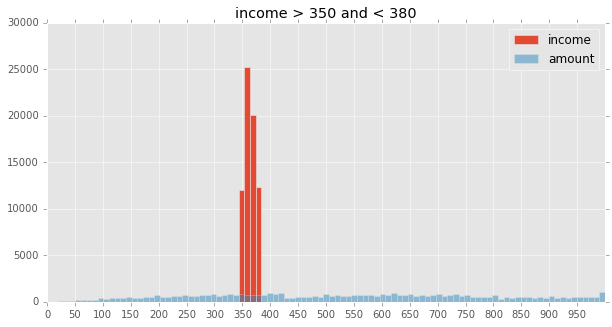

name 380 to 410
std 445.781125463
mean 718.743976333
median 645.0
max_mult 38.1679389313
med_mult 1.63727959697733
min_mult 0.0025
q98 1820.0
q02 104.0
q75 960.0
q25 380.0
iqr 580.0
min_q -490.0
max_q 1830.0
count of loans 56112
pct of total loans 2.43284655013


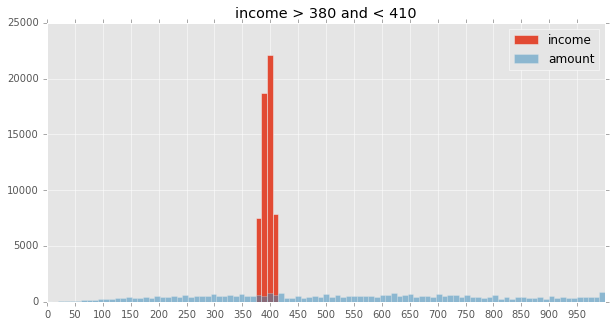

name 410 to 440
std 476.528081631
mean 763.113144211
median 685.0
max_mult 23.7677725118
med_mult 1.6173708920187793
min_mult 0.00231481481481
q98 1934.44
q02 103.0
q75 1015.5
q25 400.0
iqr 615.5
min_q -523.25
max_q 1938.75
count of loans 45579
pct of total loans 1.97616753829


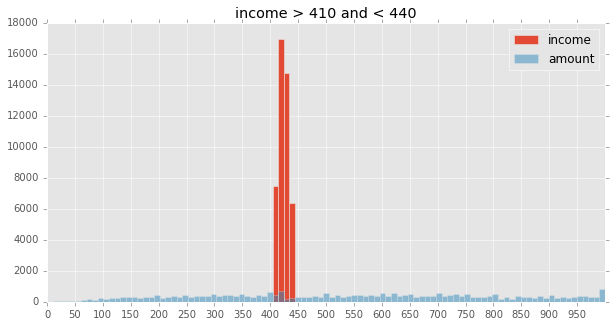

name 440 to 470
std 711.651595747
mean 792.706612869
median 700.0
max_mult 219.296052632
med_mult 1.5532393347794649
min_mult 0.00226757369615
q98 2000.0
q02 103.0
q75 1071.0
q25 400.0
iqr 671.0
min_q -606.5
max_q 2077.5
count of loans 38168
pct of total loans 1.65484900067


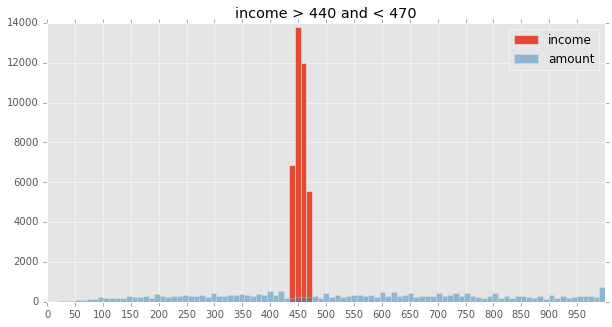

name 470 to 500
std 531.399296343
mean 820.015941671
median 720.0
max_mult 14.1975308642
med_mult 1.4869739478957915
min_mult 0.0020325203252
q98 2100.0
q02 101.0
q75 1120.0
q25 410.0
iqr 710.0
min_q -655.0
max_q 2185.0
count of loans 32368
pct of total loans 1.40337854888


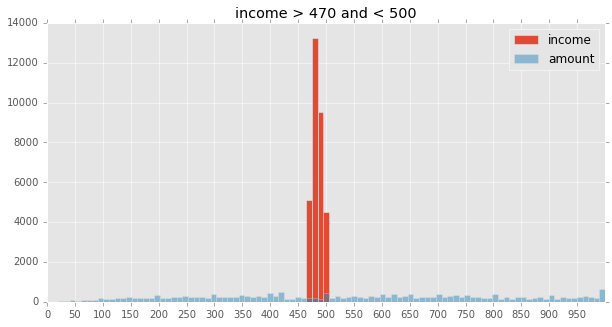

name 500 to 530
std 577.88465989
mean 858.927043855
median 745.0
max_mult 33.0097087379
med_mult 1.4531243440461332
min_mult 0.00196078431373
q98 2275.98
q02 108.0
q75 1184.0
q25 417.0
iqr 767.0
min_q -733.5
max_q 2334.5
count of loans 29552
pct of total loans 1.28128530884


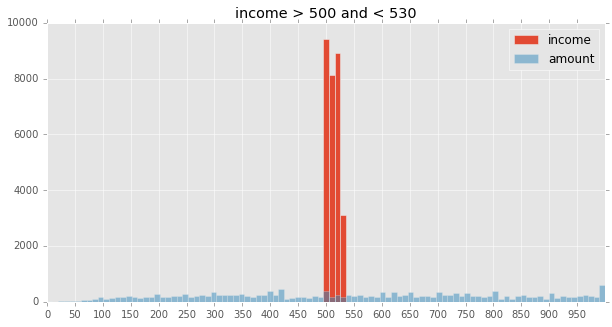

name 530 to 560
std 593.375195653
mean 887.196500673
median 760.0
max_mult 16.5441176471
med_mult 1.4005488005699729
min_mult 0.0179211469534
q98 2400.0
q02 105.0
q75 1228.0
q25 417.0
iqr 811.0
min_q -799.5
max_q 2444.5
count of loans 23776
pct of total loans 1.03085542443


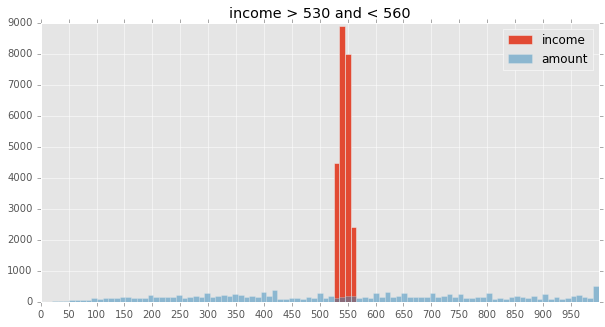

name 560 to 590
std 608.327025939
mean 911.739979232
median 796.0
max_mult 26.5486725664
med_mult 1.3808707016254185
min_mult 0.00520833333333
q98 2400.0
q02 105.0
q75 1265.0
q25 431.0
iqr 834.0
min_q -820.0
max_q 2516.0
count of loans 19260
pct of total loans 0.835055327835


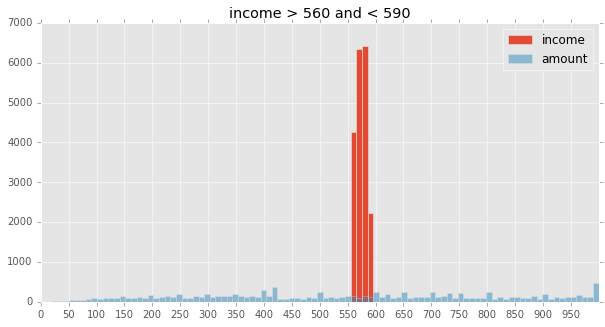

name 590 to 620
std 644.412319408
mean 938.047450756
median 800.0
max_mult 22.8155339806
med_mult 1.3305785123966942
min_mult 0.0016583747927
q98 2550.0
q02 101.0
q75 1300.0
q25 427.0
iqr 873.0
min_q -882.5
max_q 2609.5
count of loans 19241
pct of total loans 0.834231545321


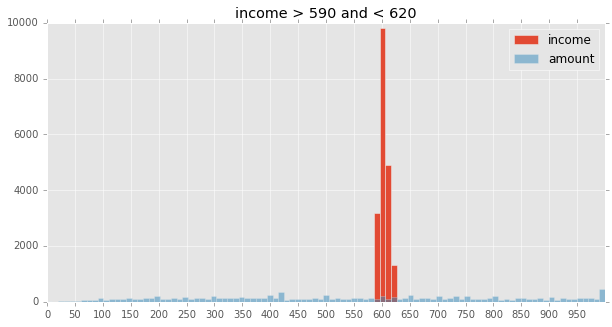

name 620 to 650
std 658.566075273
mean 963.518949835
median 828.0
max_mult 10.9204368175
med_mult 1.3097831984201047
min_mult 0.00156494522692
q98 2639.12
q02 105.0
q75 1346.0
q25 434.0
iqr 912.0
min_q -934.0
max_q 2714.0
count of loans 14512
pct of total loans 0.629196413164


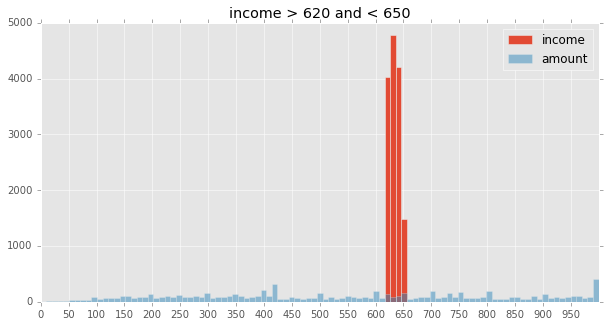

name 650 to 680
std 703.054815682
mean 1000.24726757
median 860.0
max_mult 14.8148148148
med_mult 1.2983133380381089
min_mult 0.00150602409639
q98 2749.22
q02 110.0
q75 1400.0
q25 448.0
iqr 952.0
min_q -980.0
max_q 2828.0
count of loans 14090
pct of total loans 0.610899769948


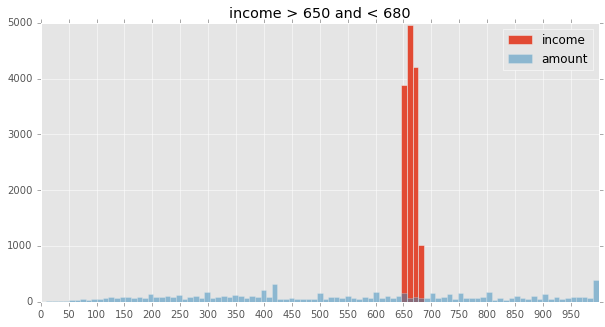

name 680 to 710
std 700.655480121
mean 1014.4710627
median 880.0
max_mult 9.28571428571
med_mult 1.2634630053394356
min_mult 0.0113798008535
q98 2813.5
q02 115.0
q75 1400.0
q25 466.0
iqr 934.0
min_q -935.0
max_q 2801.0
count of loans 12026
pct of total loans 0.521410974691


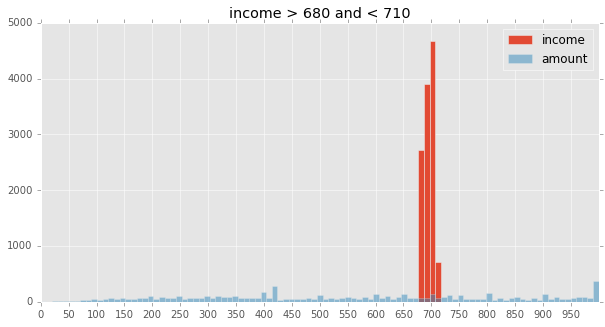

name 710 to 740
std 758.885082453
mean 1053.11549321
median 900.0
max_mult 14.8965517241
med_mult 1.2413793103448276
min_mult 0.00138888888889
q98 3000.0
q02 100.0
q75 1470.0
q25 473.0
iqr 997.0
min_q -1022.5
max_q 2965.5
count of loans 10979
pct of total loans 0.476016222446


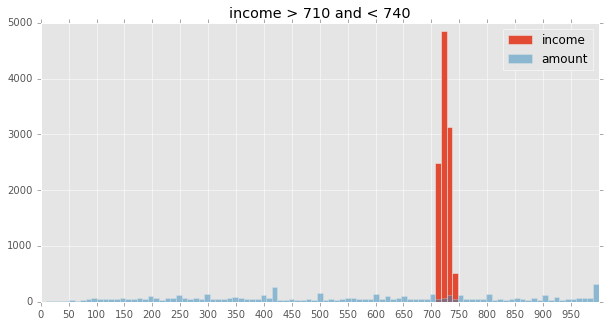

In [75]:
#Cycle over different income bins and plot loan amount distribution for each
#focus on finding the best bins
#repeat for different SQL selection filters (junior liens, non-owner-occupied, VA/FHA/RHS loans, manufactured housing)
bin_min = 0
bin_max = 20
bin_step = 30
pct_of_loans = OrderedDict({})
first = True
while bin_max < 751:
    graph_bin = bank_df[(bank_df.income >=bin_min) & (bank_df.income < bin_max)] #create bin of of amount for selected income
    #set descriptive stats
    bin_stats = OrderedDict({})
    bin_stats['name'] = str(bin_min) + ' to ' + str(bin_max)
    bin_stats['std']= graph_bin.amount.std()
    bin_stats['mean'] = graph_bin.amount.mean()
    bin_stats['median'] = graph_bin.amount.median()
    bin_stats['max_mult'] = graph_bin.mult.max()
    bin_stats['med_mult'] = graph_bin.mult.median()
    bin_stats['min_mult'] = graph_bin.mult.min()
    bin_stats['q98'] = graph_bin.amount.quantile(q=.98)
    bin_stats['q02'] = graph_bin.amount.quantile(q=.02)
    bin_stats['q75'] = graph_bin.amount.quantile(q=.75)
    bin_stats['q25'] = graph_bin.amount.quantile(q=.25)
    bin_stats['iqr'] = bin_stats['q75'] - bin_stats['q25']
    bin_stats['min_q'] = bin_stats['q25'] - 1.5 * bin_stats['iqr']
    bin_stats['max_q'] = bin_stats['q75'] + 1.5 * bin_stats['iqr']
    bin_stats['count of loans'] = graph_bin.amount.count()
    bin_stats['pct of total loans'] = (graph_bin.amount.count() / bank_df.income.count()) * 100
    
    if first:
        first=False
        bin_df = pd.DataFrame(bin_stats, index=range(1))
    else:

        concat_df = pd.DataFrame(bin_stats, index=range(1))
        bin_df = pd.concat([bin_df, concat_df], axis=0)
    for key, value in bin_stats.items():
        print(key,value)
    
    amt = graph_bin.amount#.apply(sqrt)
    inc = graph_bin.income#.apply(sqrt) #square roots show much nicer distributions of amount to income
    xmin = 0 #set minimum x axis value
    xmax = 1000 #set maximum x axis value
    xsteps= 100 #set steps on x axis (bins)
    bins = np.linspace(xmin,xmax, xsteps)
    #print(bins)
    bin_viz = plt.figure(figsize=(10,5))
    plt.hist(inc, bins, label='income', alpha=1)
    plt.hist(amt, bins, label='amount', alpha=.5)
    plt.title('income > '+str(bin_min)+' and < '+str(bin_max))
    plt.legend(loc='upper right')
    plt.xticks(np.arange(xmin,xmax, 50))
    ax = plt.subplot()
    #ax.set_ylim(0, 2000)
    plt.show(bin_viz)
    bin_min=bin_max
    bin_max += bin_step
    pct_of_loans[bin_max] = bin_stats['pct of total loans']
bin_df.reset_index(inplace=True, drop=True)
path = 'linked_dist_stats/'
if not os.path.exists(path):
    os.makedirs(path)
bin_df.to_csv(path+'no_mod' + loanType + '.csv')

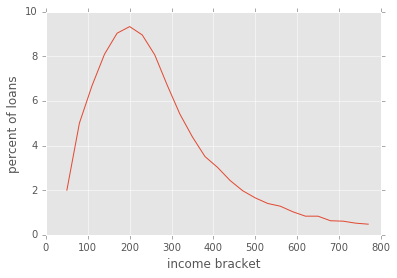

In [76]:
#graph percent of loans by top of income bin
y = []
x = []
for key, value in pct_of_loans.items():
    y.append(value)
    x.append(key)
plt.xlabel('income bracket')
plt.ylabel('percent of loans')
plt.plot(x,y)


In [77]:
#make data adjustments and calculate desc stat deltas and regraph
#use this work to refine income bins and associated loan amount distributions
bin_df.head(100)


,name,std,mean,median,max_mult,med_mult,min_mult,q98,q02,q75,q25,iqr,min_q,max_q,count of loans,pct of total loans
0,0 to 20,192.732893,167.342617,127.0,6000.000000,12.090909,0.052632,620.00,8.0,212.0,65.0,147.0,-155.50,432.50,46101,1.998800
1,20 to 50,564.708254,205.616112,177.0,2375.000000,5.121951,0.020408,600.00,9.0,273.0,89.0,184.0,-187.00,549.00,115479,5.006820
2,50 to 80,462.066157,256.300641,238.0,1718.518519,3.697368,0.012658,635.00,14.0,356.0,122.0,234.0,-229.00,707.00,154011,6.677451
3,80 to 110,412.562600,311.162530,297.0,1060.000000,3.141304,0.009174,700.00,24.0,440.0,155.0,285.0,-272.50,867.50,186685,8.094097
4,110 to 140,292.424861,359.119924,345.0,646.363636,2.770992,0.007194,785.00,35.0,507.0,187.0,320.0,-293.00,987.00,208324,9.032298
5,140 to 170,234.144989,400.688437,381.0,59.602649,2.468966,0.005917,900.00,50.0,557.0,217.0,340.0,-293.00,1067.00,215154,9.328426
6,170 to 200,253.309897,440.316250,412.0,65.934066,2.242938,0.005025,987.00,63.0,601.0,247.0,354.0,-284.00,1132.00,206571,8.956294
7,200 to 230,315.770976,482.859347,451.0,315.492958,2.107623,0.004425,1105.00,76.0,648.0,276.0,372.0,-282.00,1206.00,185926,8.061189
8,230 to 260,311.684552,526.004346,492.0,84.033613,2.016667,0.003953,1250.00,85.0,700.0,301.0,399.0,-297.50,1298.50,154381,6.693493
9,260 to 290,451.965428,566.985719,527.0,293.165468,1.926316,0.003534,1357.00,95.0,744.0,323.0,421.0,-308.50,1375.50,124780,5.410083


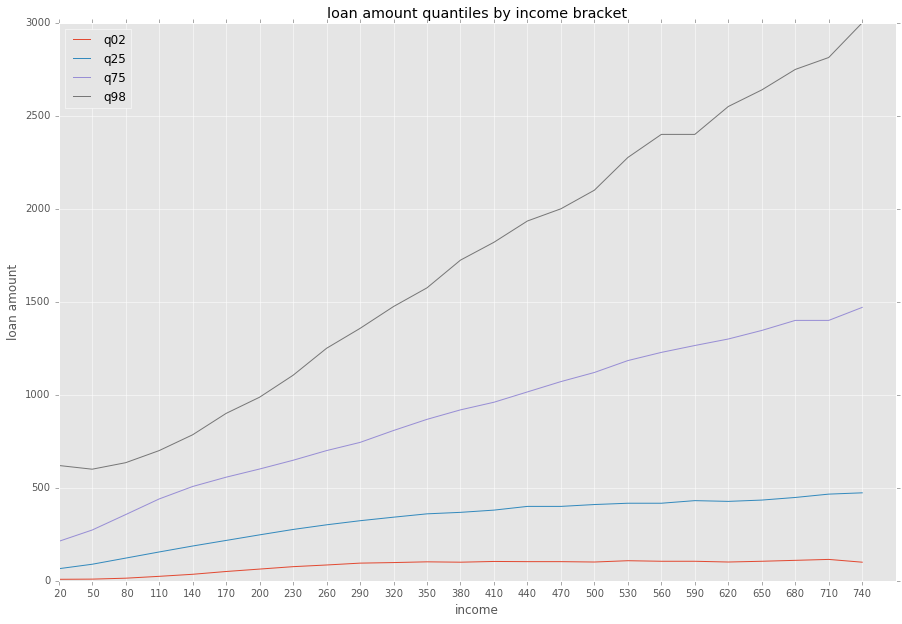

In [78]:
fig = plt.figure(figsize=(15,10))
xticks=[x[-3:] for x in bin_df.name] #get xtick names as list
ax = plt.subplot()

x = range(len(bin_df.name))

y = bin_df.q02
y1 = bin_df.q25
y2 = bin_df.q75
y3 = bin_df.q98
plt.plot(x,y, label='q02')
plt.plot(x,y1, label='q25')
plt.plot(x,y2, label='q75')
plt.plot(x,y3, label='q98')
plt.ylabel('loan amount')
plt.xlabel('income')
plt.legend(loc='upper left') #turn on legend and set location
plt.title('loan amount quantiles by income bracket')
plt.xticks(x,xticks) #set xtick names
plt.show(fig)
